In [1]:
import tensorflow as tf
import os
import numpy as np
from scipy import misc
import sys
from random import shuffle
from random import uniform
import zipfile
from collections import OrderedDict
import glob
import time
from PIL import Image
from moviepy.editor import VideoFileClip
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
gt_train_path = '/data2/cityscapes_dataset/gtFine/train'
imgs_train_path = '/data2/cityscapes_dataset/leftImg8bit/train'
gt_val_path = '/data2/cityscapes_dataset/gtFine/val'
imgs_val_path = '/data2/cityscapes_dataset/leftImg8bit/val'
gt_test_path = '/data2/cityscapes_dataset/gtFine/test'
imgs_test_path = '/data2/cityscapes_dataset/leftImg8bit/test'

In [4]:
# Get training data filenames
def get_files(imgs_dir, gt_dir):
    
    cities = os.listdir(imgs_dir)
    gt = []
    imgs = []
    for city in cities:
        new_gt_path = os.path.join(gt_dir, city)
        new_imgs_path = os.path.join(imgs_dir, city)
        gt += glob.glob(os.path.join(new_gt_path, "*labelIds.png"))
        imgs += glob.glob(os.path.join(new_imgs_path, "*.png"))
    imgs.sort()
    gt.sort()
    return imgs, gt

In [5]:
train_imgs, train_gt = get_files(imgs_train_path, gt_train_path)
val_imgs, val_gt = get_files(imgs_val_path, gt_val_path)
test_imgs, test_gt = get_files(imgs_test_path, gt_test_path)

In [6]:
type(train_imgs), len(train_imgs), train_imgs[0]

(list,
 2975,
 '/data2/cityscapes_dataset/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png')

In [7]:
# random image for unit tests
random_im_path = '/data2/cityscapes_dataset/leftImg8bit/train/jena/jena_000118_000019_leftImg8bit.png'
random_gt_path = '/data2/cityscapes_dataset/gtFine/train/jena/jena_000118_000019_gtFine_color.png'
random_instance_path = '/data2/cityscapes_dataset/gtFine/train/jena/jena_000118_000019_gtFine_instanceIds.png'
random_label_path = '/data2/cityscapes_dataset/gtFine/train/jena/jena_000118_000019_gtFine_labelIds.png'

In [8]:
# downloaded into current directory from ftp://mi.eng.cam.ac.uk/pub/mttt2/models/vgg16.npy
vgg_path = 'vgg16.npy'
# From the VGG paper
vgg_means = [103.939, 116.779, 123.68]

# Utility Functions

In [9]:
def plot_image(image_path=None, img=None, from_path=True):
    if (from_path == True):
        img = misc.imread(image_path)
    if len(img.shape) == 4:
        img = np.squeeze(img)
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)
    plt.imshow(img)
    plt.show()

In [10]:
# prepare_ground_truth for cityscape data
def prepare_ground_truth(img):
    
    # Five classes: road, side_walk, pedestrian, vehicles, others
    NUM_CLASSES = 5
    new_image = np.zeros((img.shape[0], img.shape[1], NUM_CLASSES))
    
    # (original_id)
    # road
    road_mask = img == 7
    # sidewalk 
    side_mask = img == 8
    # pedestrians[person,rider]
    ped_mask = np.logical_or(img == 24, img == 25)
    # vehicles[car,truck,bus,caravan,trailer,train,motorcycle, bicycle, license plate]
    car_mask = np.logical_or.reduce((img == 26, img == 27, img == 28,
                                      img == 29, img == 30, img == 31,
                                      img == 32, img == 33, img == -1))
    # everything else
    else_mask = np.logical_not(np.logical_or.reduce((road_mask, side_mask,
                                                     ped_mask, car_mask)))
    
    new_image[:,:,0] = road_mask
    new_image[:,:,1] = side_mask
    new_image[:,:,2] = ped_mask
    new_image[:,:,3] = car_mask
    new_image[:,:,4] = else_mask
    
    return new_image.astype(np.float32)

In [12]:
tmp = shape_im = misc.imread(random_im_path)

In [13]:
tmp.shape

(1024, 2048, 3)

In [14]:
def get_data(batch_size=1, num_classes=5, mode='train', imgs=train_imgs, gt=train_gt, im_size=500):
    
    # Expects sorted lists of training images and ground truth as
    # 'data' and 'labels'
    if (mode == 'val'):
        imgs = val_imgs
        gt = val_gt
    elif (mode == 'test'):
        imgs = test_imgs
        gt = test_gt
    
    # get shape from any image
    shape_im = misc.imread(random_im_path)
    
    # Shuffle dataset
    if mode=='train':
        combined = list(zip(imgs, gt))
        shuffle(combined)
        imgs[:], gt[:] = zip(*combined)
    
    while(True):
        for i in range(0,len(imgs),batch_size):
            images = np.empty((batch_size, im_size, im_size, shape_im.shape[2]))
            labels = np.empty((batch_size, im_size, im_size, num_classes))
            for j, img in enumerate(imgs[i:i+batch_size]):
                # Crop the size we want from a random spot in the image (as a form of
                # minor data augmentation)
                new_start_row = np.random.randint(0, shape_im.shape[0] - im_size)
                new_start_col = np.random.randint(0, shape_im.shape[1] - im_size)
                train_im = misc.imread(img).astype(np.float32)
                
                train_im = train_im[new_start_row:new_start_row+im_size, new_start_col:new_start_col+im_size]
                images[j,:,:,:] = train_im
                
                gt_im = misc.imread(gt[i+j])
                gt_im = gt_im[new_start_row:new_start_row+im_size, new_start_col:new_start_col+im_size]
                labels[j,:,:,:] = prepare_ground_truth(gt_im)
            
            yield(images,labels)
            

In [15]:
# visualize_prediction for cityscape data
def visualize_prediction(original_image, prediction):
    
    original_image = np.squeeze(original_image).astype(np.uint8)
    new_image = np.copy(original_image)
    prediction = np.squeeze(prediction)
    mask = np.argmax(prediction, axis=2)
    # road = green
    new_image[mask[:,:]==0, :] = [0,255,0]
    # sidewalk = blue
    new_image[mask[:,:]==1, :] = [0,0,255]
    # pedestrians = yellow
    new_image[mask[:,:]==2, :] = [255,255,0]
    # vehicles = red
    new_image[mask[:,:]==3, :] = [255,0,0]
    # else is left the same
    
    new_image = Image.blend(Image.fromarray(original_image, mode='RGB').convert('RGBA'),
                            Image.fromarray(new_image, mode='RGB').convert('RGBA'),
                            alpha=0.5)
    
    plt.imshow(new_image, interpolation='nearest')
    plt.show()

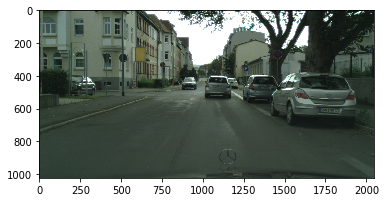

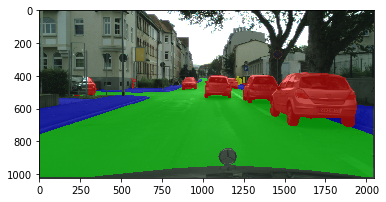

In [16]:
# Check the visualization with ground truth
rand_gt = misc.imread(random_label_path)
rand_im = misc.imread(random_im_path)
plot_image(img=rand_im, from_path=False)
prepped = prepare_ground_truth(rand_gt)
visualize_prediction(rand_im, prepped)

# Model-Building Functions

In [17]:
def vgg_conv(layer_input, vgg_dict, bn, name):
    
    with tf.variable_scope(name):
        
        # Get the conv filter
        init = tf.constant_initializer(value=vgg_dict[name][0], dtype=tf.float32)
        shape = vgg_dict[name][0].shape
        filt = tf.get_variable(name="filter", initializer=init, shape=shape)
        # Get the conv bias
        init = tf.constant_initializer(value=vgg_dict[name][1], dtype=tf.float32)
        shape = vgg_dict[name][1].shape
        bias = tf.get_variable(name="biases", initializer=init, shape=shape)
        # Construct conv layer
        conv = tf.nn.conv2d(layer_input, filt, [1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, bias), name=name)
        return tf.contrib.layers.batch_norm(relu, center=True, scale=True, is_training=True)

In [18]:
# Helper function for deconvolutional layers
# Note that this function is different than the Unet deconv functions
def deconv2d(layer_input, output_shape, input_fsize, output_fsize, filter_size, stride, bn, name):
    w = tf.get_variable("filter_" + name, shape=[filter_size, filter_size, output_fsize, input_fsize], 
                        initializer=tf.contrib.layers.xavier_initializer_conv2d(), 
                        regularizer=tf.contrib.layers.l2_regularizer(.001))
    b = tf.Variable(tf.constant(0.1, shape=[output_fsize]))
    new_shape = tf.stack([output_shape[0], output_shape[1], output_shape[2], output_fsize])
    deconv = tf.nn.conv2d_transpose(layer_input, w, new_shape, strides=[1, stride, stride, 1], padding='SAME')
    layer = tf.nn.elu(tf.add(deconv, b))
    return tf.contrib.layers.batch_norm(layer, center=True, scale=True, is_training=True)

In [19]:
def conv_layer(layer_input, input_fsize, output_fsize, filter_size, bn, name):
    w = tf.get_variable("filter_" + name, shape=[filter_size, filter_size, input_fsize, output_fsize], 
                        initializer=tf.contrib.layers.xavier_initializer_conv2d(), 
                        regularizer=tf.contrib.layers.l2_regularizer(.001))
    b = tf.Variable(tf.constant(0.1, shape=[output_fsize]))
    layer = tf.nn.elu(tf.add(tf.nn.conv2d(layer_input, w, strides=[1, 1, 1, 1], padding='SAME'), b))
    return tf.contrib.layers.batch_norm(layer, center=True, scale=True, is_training=True)


# Construct Model

In [20]:
def create_FCN_VGG(imgs, vgg_dict, dropout=0.5, channels=3, num_classes=5, filter_size=1, bn=True):
    
    im_rows = tf.shape(imgs)[1]
    im_cols = tf.shape(imgs)[2]
    
    x_image = tf.reshape(imgs, tf.stack([-1,im_rows,im_cols,channels]))
    layer_input = x_image
    batch_size = tf.shape(x_image)[0]
    
    # VGG pre-processing
    red, green, blue = tf.split(x_image, 3, 3)

    x_image = tf.concat([
        blue - vgg_means[0],
        green - vgg_means[1],
        red - vgg_means[2]], axis=3)
    
    x_image = x_image / 122.5
    
    # Encoder
    conv1_1 = vgg_conv(x_image, vgg_dict, bn, "conv1_1")
    conv1_2 = vgg_conv(conv1_1, vgg_dict, bn, "conv1_2")
    pool1 = tf.nn.max_pool(conv1_2, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME', name="pool1")
    conv2_1 = vgg_conv(pool1, vgg_dict, bn, "conv2_1")
    conv2_2 = vgg_conv(conv2_1, vgg_dict, bn, "conv2_2")
    pool2 = tf.nn.max_pool(conv2_2, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME', name="pool2")
    conv3_1 = vgg_conv(pool2, vgg_dict, bn, "conv3_1")
    conv3_2 = vgg_conv(conv3_1, vgg_dict, bn, "conv3_2")
    conv3_3 = vgg_conv(conv3_2, vgg_dict, bn, "conv3_3")
    pool3 = tf.nn.max_pool(conv3_3, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME', name="pool3")
    conv4_1 = vgg_conv(pool3, vgg_dict, bn, "conv4_1")
    conv4_2 = vgg_conv(conv4_1, vgg_dict, bn, "conv4_2")
    conv4_3 = vgg_conv(conv4_2, vgg_dict, bn, "conv4_3")
    pool4 = tf.nn.max_pool(conv4_3, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME', name="pool4")
    conv5_1 = vgg_conv(pool4, vgg_dict, bn, "conv5_1")
    conv5_2 = vgg_conv(conv5_1, vgg_dict, bn, "conv5_2")
    conv5_3 = vgg_conv(conv5_2, vgg_dict, bn, "conv5_3")
    pool5 = tf.nn.max_pool(conv5_3, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME', name="pool5")

    # VGG depth at the fifth layer (comes from imported weights so
    # it will be constant no matter the size of input image)
    features = 512
        
    # Decoder
    # Combo layer 1
    d_conv1 = conv_layer(pool5, features, num_classes, filter_size, bn, "decoder_c1")
    d_dconv1 = deconv2d(d_conv1, tf.shape(pool4), num_classes, num_classes, 4, 2, bn, "decoder_d1")
    
    d_conv2 = conv_layer(pool4, features, num_classes, filter_size, bn, "decoder_c2")
    
    # Skip connection
    d_sum1 = tf.add(d_dconv1, d_conv2)
    
    # Combo layer 2
    d_dconv2 = deconv2d(d_sum1, tf.shape(pool3), num_classes, num_classes, 4, 2, bn, "decoder_d2")
    
    d_conv3 = conv_layer(pool3, features//2, num_classes, filter_size, bn, "decoder_c3")
    
    # Skip connection
    d_sum2 = tf.add(d_dconv2, d_conv3)
    
    # Combo layer 3
    d_dconv3 = deconv2d(d_sum2, tf.shape(x_image), num_classes, num_classes, 16, 8, bn, "decoder_d3")

    output = d_dconv3
        
    return output


In [21]:
class FCN_VGG:
    
    def __init__(self, channels=3, num_classes=5, output_path='./output'):
        
        # prediction path is to store validation prediction images in if necessary
        self.prediction_path = "./predictions"
        
        # output path for trained model 
        self.output_path = output_path
        
        if not os.path.exists(self.prediction_path):
            os.mkdir(self.prediction_path)
        if not os.path.exists(self.output_path):
            os.mkdir(self.output_path)
                
        tf.reset_default_graph()
        
        self.num_classes = num_classes
        
        # load the VGG weights : vgg16.npy
        self.vgg_dict = np.load(vgg_path, encoding='latin1').item()
        
        # images as input
        self.x = tf.placeholder("float", shape=[None, None, None, channels], name="x")
        
        # prediction output
        self.y = tf.placeholder("float", shape=[None, None, None, num_classes], name="y")
        
        # dropout prob.
        self.drop_pl = tf.placeholder("float", name="do")
        
        # batch norm
        self.bn = tf.placeholder("bool", name="bn")
        
        # output logit
        logits = create_FCN_VGG(self.x, self.vgg_dict, dropout=self.drop_pl, channels=channels, num_classes=num_classes)
        self.logits = logits
        
        # convert to prob. using softmax
        self.soft = self.pixel_wise_softmax(logits)
        self.soft = tf.identity(self.soft, name="output")
        self.loss = self.get_loss(logits)
                
        # These two are for validation
        self.correct_pred = tf.equal(tf.argmax(tf.squeeze(self.soft), -1), tf.argmax(tf.squeeze(self.y), -1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
            
    # A helper function for computing softmax across the channel-dimension
    def pixel_wise_softmax(self, output):
                
        # Softmax across the last dimension (where each channel is a binary image
        # denoting whether the pixel belongs in that category or not -- this allows
        # for more than two classes)
        # e^x
        
        # output is logits
        exponential_map = tf.exp(output)
        # sum-e^x
        sum_exp = tf.reduce_sum(exponential_map, 3, keep_dims=True)
        # duplicate the last summed dimension
        tensor_sum_exp = tf.tile(sum_exp, tf.stack([1, 1, 1, tf.shape(output)[3]]))
        # divide e^x by sum-e^x 
        return tf.div(exponential_map, tensor_sum_exp)
        
    def get_loss(self, logits):

        cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=self.y, logits=logits))
        
        reg_loss = sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
        
        cost += reg_loss
        
        return cost

    
    def predict(self, model_path, img, gt=None, restore=True):
    
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            
            sess.run(init)
            # model_path = 'fcn_vgg_city2.ckpt'
            if restore:
                self.restore(sess, os.path.join(self.output_path, model_path))
            
            if gt != None:
                soft, acc = sess.run([self.soft, self.accuracy], feed_dict={self.x: img, self.y: gt,
                                                                            self.drop_pl: 1.0, self.bn: False})
                return soft, acc
            else:
                soft = sess.run(self.soft, feed_dict={self.x: img, self.drop_pl: 1.0, self.bn: False})
                return soft
    
    def save(self, sess, model_path):
        # save the variabless in sess (including weights and model structures) into model_path ('fcn_vgg_city2.ckpt')
        saver = tf.train.Saver()
        save_path = saver.save(sess, model_path)
        return save_path
    
    def restore(self, sess, model_path):
        
        saver = tf.train.Saver()
        saver.restore(sess, model_path)
    
    def train(self, data_generator, dropout=0.5, training_iters=10, learning_rate=0.0001, epochs=10, display_step=10, restore=False, model_path=None):
        # output_path = './output', model_path = 'fcn_vgg_city2.ckpt'
        # then model_path = './output/fcn_vgg_city2.ckpt'
        model_path = os.path.join(self.output_path, model_path)
                
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)
        
        init = tf.global_variables_initializer()
        
        with tf.Session() as sess:
            
            print("Session begun")
            
            sess.run(init)
        
            if restore:
                self.restore(sess, model_path)

            for epoch in range(epochs):
                
                print("Starting new epoch")
                
                total_loss = 0.0
                display_loss = 0.0
                display_acc = 0.0
                best_acc = .93
                for step in range((epoch*training_iters), ((epoch+1)*training_iters)):
                    
                    x_batch, y_batch = next(data_generator)
                    
                    _, loss, acc, logits = sess.run((self.optimizer, self.loss, self.accuracy, self.logits),
                                                    feed_dict={self.x: x_batch,
                                                              self.y: y_batch,
                                                              self.drop_pl: dropout,
                                                              self.bn: True})
                    
                    display_loss += loss
                    display_acc += acc
                    
                    if ((step+1) % display_step == 0):
                        print("At iteration {} loss equals {} and accuracy equals {}".format(step+1, display_loss/(display_step), display_acc/(display_step)))
                        
                        if ((display_acc/(display_step)) > best_acc):
                            save_path = self.save(sess, os.path.join(self.output_path, model_path))
                            best_acc = display_acc/display_step
                            print("model saved")
                        total_loss += display_loss
                        display_loss = 0.0
                        display_acc = 0.0
                        
                                                                    
                print("###############################")
                print("Epoch", epoch + 1, "average loss =", total_loss/training_iters)
                print("###############################")
                total_loss = 0                
                
            #save_path = self.save(sess, os.path.join(self.output_path, model_path))
            save_path = self.save(sess, os.path.join(model_path))
        
        return save_path

# Train Model

In [22]:
tf.reset_default_graph()

In [23]:
my_fcn = FCN_VGG()

In [27]:
# Not enough RAM for large batch given
# the size of these images
batch_generator = get_data(mode='train', batch_size=1, im_size=1000)
#batch_generator = get_data(mode='val', batch_size=10, im_size=500)
model_path = 'fcn_vgg_city_new3.ckpt'

In [28]:
output_path = my_fcn.train(batch_generator, learning_rate=8e-4,
                          training_iters=2000, epochs=1, display_step=100,
                          restore=False, model_path=model_path)

Session begun
Starting new epoch
At iteration 100 loss equals 1216191.875625 and accuracy equals 0.6216270634531975
At iteration 200 loss equals 959165.32375 and accuracy equals 0.7821272179484368
At iteration 300 loss equals 858972.704375 and accuracy equals 0.8089333935081959
At iteration 400 loss equals 748199.134375 and accuracy equals 0.8262724173069
At iteration 500 loss equals 725047.78125 and accuracy equals 0.8273192027211189
At iteration 600 loss equals 679800.8325 and accuracy equals 0.8368475866317749
At iteration 700 loss equals 640914.0409375 and accuracy equals 0.840430109500885
At iteration 800 loss equals 579411.204375 and accuracy equals 0.8585280025005341
At iteration 900 loss equals 560286.240625 and accuracy equals 0.86028777718544
At iteration 1000 loss equals 585610.9271875 and accuracy equals 0.851527356505394
At iteration 1100 loss equals 562627.913125 and accuracy equals 0.84534254103899
At iteration 1200 loss equals 504579.7775 and accuracy equals 0.866699260

# Test Model

In [23]:
# the input image will be cropped 1000x1000 patch
val_batch_generator = get_data(mode='val', im_size=1000)

In [28]:
val_batch_generator.

In [24]:
val_img, val_gt = next(val_batch_generator)

In [30]:
type(val_img), type(val_gt)

(numpy.ndarray, numpy.ndarray)

In [31]:
val_img.shape, val_gt.shape

((1, 1000, 1000, 3), (1, 1000, 1000, 5))

In [32]:
model_path

'fcn_vgg_city_new.ckpt'

In [33]:
my_fcn.output_path

'./output'

In [36]:
soft, acc = my_fcn.predict(model_path, val_img, gt=val_gt, restore=True)

In [37]:
acc

0.67049301

In [38]:
val_img, val_gt = next(val_batch_generator)

In [39]:
soft, acc = my_fcn.predict(model_path, val_img, gt=val_gt, restore=True)
acc

0.78468162

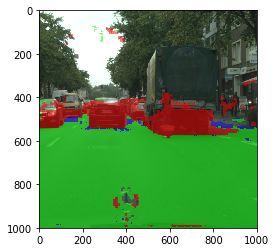

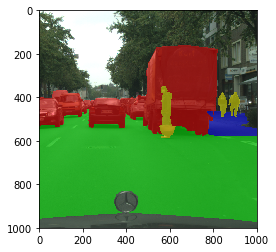

In [40]:
visualize_prediction(val_img, soft)
visualize_prediction(val_img, val_gt)

# Test on all validaton data (500 images)

In [55]:
# the input image will be cropped 1000x1000 patch
val_batch_generator = get_data(mode='val', im_size=1000)

In [56]:
val_img, val_gt = next(val_batch_generator)

AttributeError: 'numpy.ndarray' object has no attribute 'read'

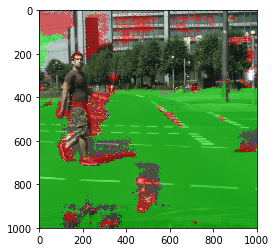

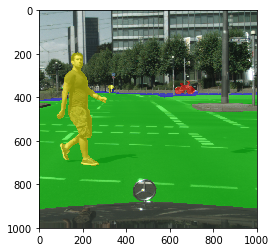

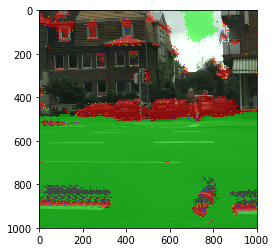

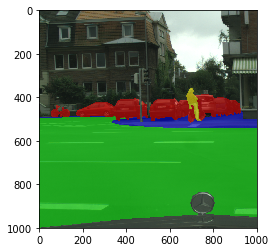

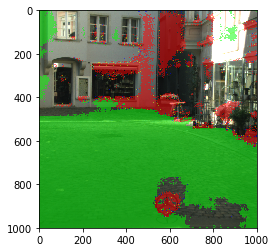

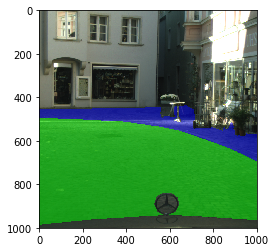

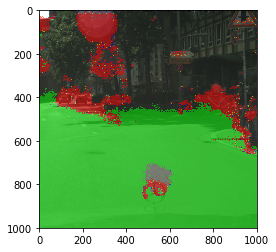

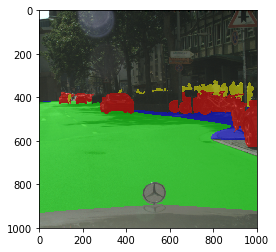

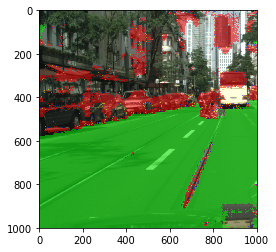

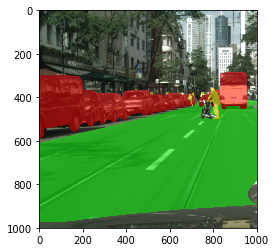

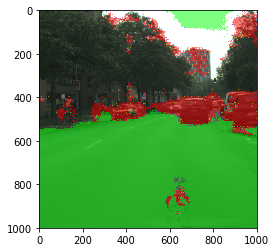

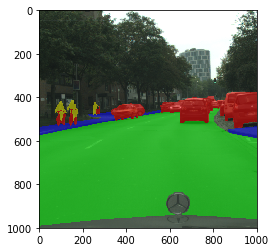

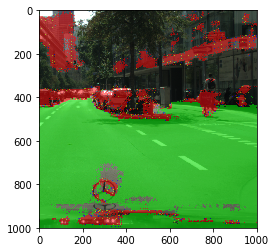

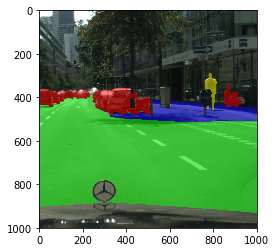

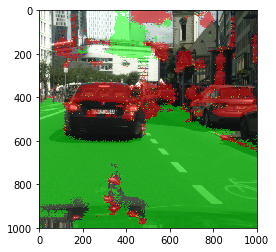

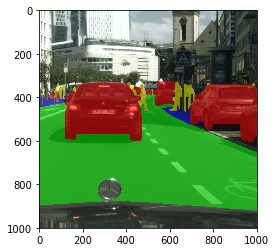

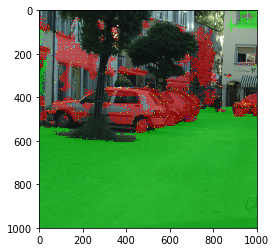

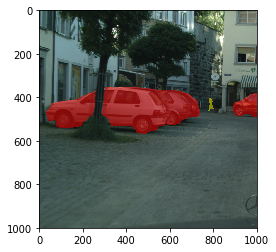

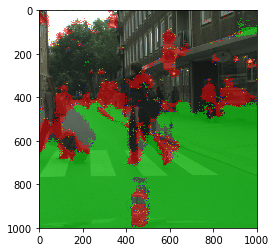

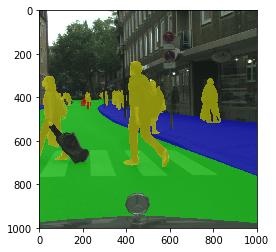

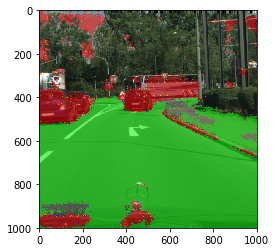

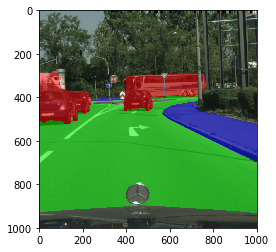

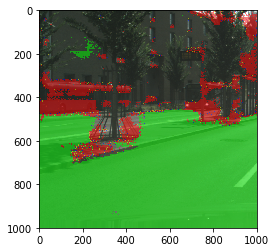

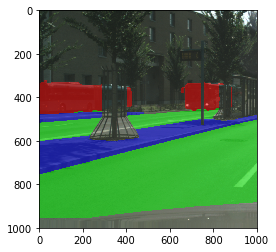

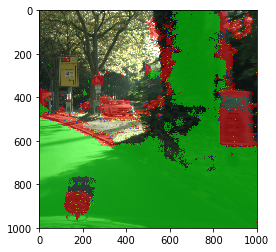

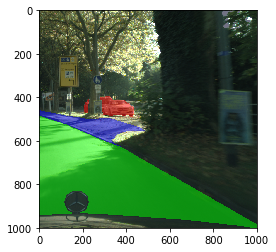

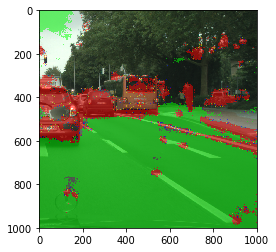

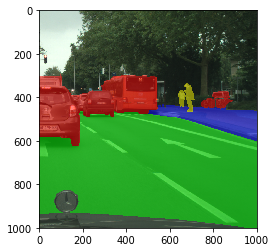

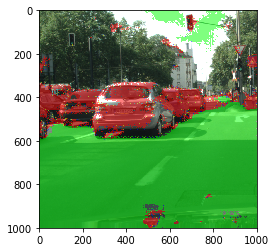

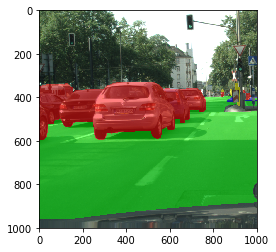

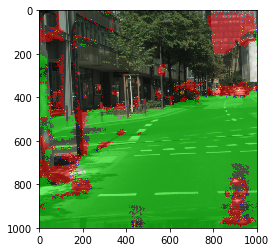

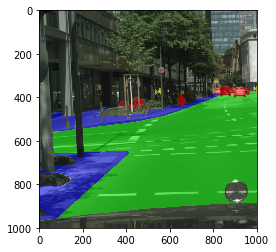

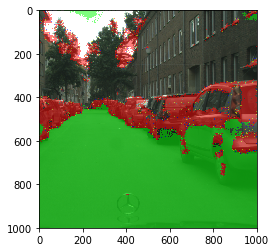

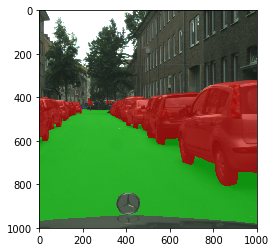

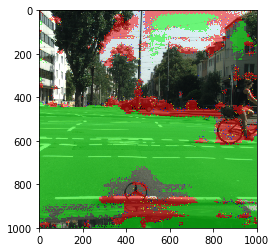

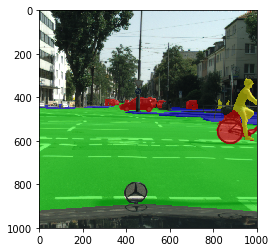

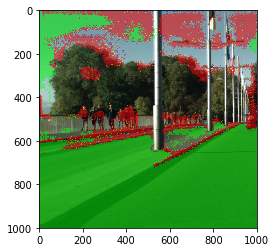

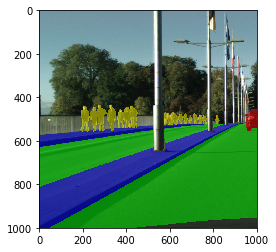

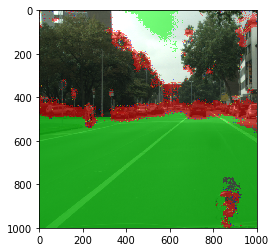

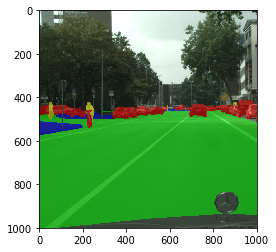

###############################
Average validation set accuracy = 0.724076759815
###############################


In [25]:
total_acc = 0.0
val_size = 20

for i in range(val_size):
    #val_img, val_gt = next(batch_generator)
    val_img, val_gt = next(val_batch_generator)
    results, acc = my_fcn.predict(model_path, val_img, gt=val_gt, restore=True)
    total_acc += acc

    visualize_prediction(val_img, results)
    visualize_prediction(val_img, val_gt)

total_acc /= val_size
print("###############################")
print("Average validation set accuracy =", total_acc)
print("###############################")

# Freeze model

In [26]:
from tensorflow.python.framework.graph_util import convert_variables_to_constants
from tensorflow.python.tools import inspect_checkpoint

In [27]:
output_path = "./output/"
checkpoint_path = tf.train.latest_checkpoint(output_path)
frozen_name = "frozen_FCN2.pb"

In [29]:
saver = tf.train.import_meta_graph(checkpoint_path + '.meta', import_scope=None)

output_node_names = "output"

with tf.Session() as sess:
    
    # Restore the variable values
    saver.restore(sess, checkpoint_path)
    # Get the graph def from our current graph
    graph_def = tf.get_default_graph().as_graph_def()
    # Turn all variables into constants
    frozen_graph_def = convert_variables_to_constants(sess, graph_def, output_node_names.split(","))
    
    # Save our new graph def
    with tf.gfile.GFile(output_path + frozen_name, "wb") as f:
        f.write(frozen_graph_def.SerializeToString())

INFO:tensorflow:Froze 76 variables.
Converted 76 variables to const ops.


# Use frozen model

In [30]:
def load_graph(my_path):
    # Load the pb file and parse it to retrieve the 
    # unserialized graph_def
    with tf.gfile.GFile(my_path, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    
    # Now import the graph_def to our default graph.
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(
            graph_def,
            input_map=None,
            return_elements=None,
            # If you put name=None here instead of ''
            # it will relabel all your ops as "import/original_name"
            name='',
            op_dict=None, 
            producer_op_list=None
        )
    # Return the loaded graph
    return graph

In [32]:
graph = load_graph('./output/frozen_FCN2.pb')

In [33]:
x = graph.get_tensor_by_name('x:0')
output = graph.get_tensor_by_name('output:0')

In [35]:
with tf.Session(graph=graph) as sess:

    %time out = sess.run(output, feed_dict={x: val_img})

CPU times: user 384 ms, sys: 40 ms, total: 424 ms
Wall time: 752 ms


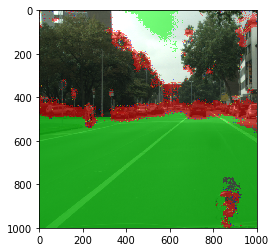

In [36]:
visualize_prediction(val_img, out)

In [37]:
# Optimize_for_inference deletes identity nodes (even if they are the output)
# so I'm searching for the name of the node before the identity I added as that
# will be the actual output
graph_def = graph.as_graph_def()
for i,node in enumerate(graph_def.node[-10:]):
    print(node)
    print(i)

name: "strided_slice_12/stack_1"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_INT32
  }
}
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_INT32
      tensor_shape {
        dim {
          size: 1
        }
      }
      int_val: 4
    }
  }
}

0
name: "strided_slice_12/stack_2"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_INT32
  }
}
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_INT32
      tensor_shape {
        dim {
          size: 1
        }
      }
      int_val: 1
    }
  }
}

1
name: "strided_slice_12"
op: "StridedSlice"
input: "Shape_6"
input: "strided_slice_12/stack"
input: "strided_slice_12/stack_1"
input: "strided_slice_12/stack_2"
attr {
  key: "Index"
  value {
    type: DT_INT32
  }
}
attr {
  key: "T"
  value {
    type: DT_INT32
  }
}
attr {
  key: "begin_mask"
  value {
    i: 0
  }
}
attr {
  key: "ellipsis_mask"
  value {
    i: 0
  }
}
attr {
  key: "end_mask"
  value {
    i: 0
  }
}
attr {
  key: "new_axis_mask

# Optimize model

In [38]:
from tensorflow.python.tools import optimize_for_inference_lib

In [39]:
graph_def_path = './output/frozen_FCN2.pb'
optimized_model = './output/optimized_FCN2.pb'

In [40]:
# Load the graph we just froze
input_graph_def = tf.GraphDef()
with tf.gfile.Open(graph_def_path, "rb") as f:
    data = f.read()
    input_graph_def.ParseFromString(data)

output_graph_def = optimize_for_inference_lib.optimize_for_inference(
        input_graph_def,
        # A list of input nodes
        ["x"],
        # A list of output nodes
        ["div"],
        tf.float32.as_datatype_enum)

# Save the optimized graph
f = tf.gfile.FastGFile(optimized_model, "wb")
f.write(output_graph_def.SerializeToString())
f.close()

# Use optimized model for prediction

In [41]:
graph = load_graph(optimized_model)

In [42]:
x = graph.get_tensor_by_name('x:0')
output = graph.get_tensor_by_name('div:0')

In [44]:
with tf.Session(graph=graph) as sess:
    %time output = sess.run(output, feed_dict={x:val_img})

CPU times: user 356 ms, sys: 28 ms, total: 384 ms
Wall time: 731 ms


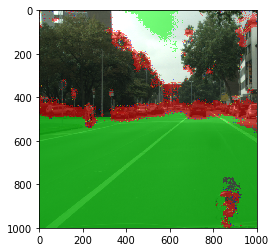

In [45]:
visualize_prediction(val_img, out)

# Test on video frame (on orginal size : 1024x2048)

In [46]:
optimized_model = './output/optimized_FCN2.pb'
graph = load_graph(optimized_model)

In [47]:
x = graph.get_tensor_by_name('x:0')
output = graph.get_tensor_by_name('div:0')

In [48]:
frame_path = '/data2/cityscapes_dataset/leftImg8bit_demoVideo/leftImg8bit/demoVideo/stuttgart_01/stuttgart_01_000000_004581_leftImg8bit.png'

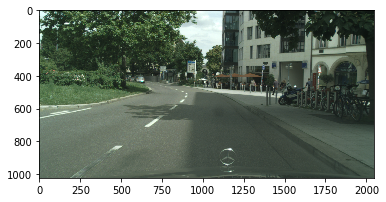

In [49]:
plot_image(image_path=frame_path)

In [50]:
img = misc.imread(frame_path).astype(np.float32)
img_arr = np.empty((1,img.shape[0],img.shape[1],img.shape[2]))
img_arr[0,:,:,:] = img

In [51]:
with tf.Session(graph=graph) as sess:
    %time result = sess.run(output, feed_dict={x: img_arr})

CPU times: user 5.38 s, sys: 880 ms, total: 6.26 s
Wall time: 6.83 s


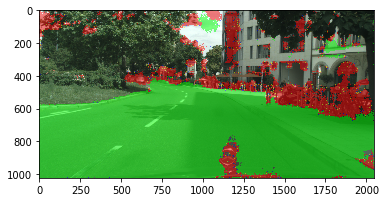

In [52]:
visualize_prediction(img_arr, result)